In [1]:
import spectrum
import pandas as pd
import astropy.constants as c
import astropy.units as u
import numpy as np
import pandas as pd
from scipy.interpolate import interp1d
from astropy.modeling.models import BlackBody
from astropy import units as u


# temperature to radius conversion for binary model
pm2013 = pd.read_csv('./data/literature_data/PecautMamajek_table.csv', 
                     skiprows=22, delim_whitespace=True).replace('...',np.nan)
teff_pm2013 = np.array([float(i) for i in pm2013['Teff']])
R_pm2013 = np.array([float(i) for i in pm2013['R_Rsun']])
mass_pm2013 = np.array([float(i) for i in pm2013['Msun']])

valid_mass = ~np.isnan(mass_pm2013)
teff2radius = interp1d(teff_pm2013[valid_mass], R_pm2013[valid_mass])


# initialize spectrum object
# (this is temporary, I'll have to think about 
# how to implement this in the code later)
binary_labels = pd.read_csv('./data/label_dataframes/known_binary_labels.csv')
binary_flux = pd.read_csv('./data/spectrum_dataframes/known_binary_flux_dwt.csv')
binary_sigma = pd.read_csv('./data/spectrum_dataframes/known_binary_sigma_dwt.csv')

In [2]:
# load spectrum objects of test cases
import thecannon as tc

# data to determine teff1, teff2 of test binaries
k16_table7 = pd.read_csv('./data/literature_data/Kraus2016/Kraus2016_Table7.csv', delim_whitespace=True)
mass2teff = interp1d(mass_pm2013[valid_mass], teff_pm2013[valid_mass])

# KOI-289: q=1 Sun-like primary
q1_k16 = k16_table7[k16_table7.KOI=='KOI-0289'].iloc[0]
q1_cks_labels = binary_labels[binary_labels.id_starname=='K00289'].iloc[0]
q1_teff1 = mass2teff(q1_k16.m2/q1_k16.q)
q1_teff2 = mass2teff(q1_k16.m2)

# KOI-291:q=0.7 Sun-like primary
q07_k16 = k16_table7[k16_table7.KOI=='KOI-0291'].iloc[0]
q07_cks_labels = binary_labels[binary_labels.id_starname=='K00291'].iloc[0]
q07_teff1 = mass2teff(q07_k16.m2/q07_k16.q)
q07_teff2 = mass2teff(q07_k16.m2)

# load spectrum objects
order_numbers = [i for i in range(1,17) if i not in (11,12)]
model = tc.CannonModel.read('./data/cannon_models/rchip_orders_11-12_omitted_dwt/rchip_orders_11-12_omitted_dwt.model')
model_wav = spectrum.w_data[[i-1 for i in order_numbers]].flatten()
q1_spec = spectrum.Spectrum(binary_flux['K00289'], binary_sigma['K00289'], order_numbers, model)
q07_spec = spectrum.Spectrum(binary_flux['K00291'], binary_sigma['K00291'], order_numbers, model)

# fit single star models to spectra
q1_spec.fit_single_star()
q07_spec.fit_single_star()

In [3]:
# functions, variables for binary model
# should I just load the wavelength values?
# or should the flux weights read in the spectrum?
# I'll take a second to think but it doesn't matter too much
# maybe for simplicity I can just load it in.
from pylab import *

def flux_weights(teff1, teff2, wav):
    """
    Returns un-normalized relative fluxes,
    based on blackbody curve * R^2
    """
    
    # blackbody functions
    bb1 = BlackBody(temperature=teff1*u.K)
    bb2 = BlackBody(temperature=teff2*u.K)
    # evaluate blackbody at model wavelengths
    bb1_curve = bb1(wav*u.AA).value
    bb2_curve = bb2(wav*u.AA).value

    # calculate unweighted flux contributions
    W1 = bb1_curve*teff2radius(teff1)**2
    W2 = bb2_curve*teff2radius(teff2)**2
    
    # normalize weights to sum to 1
    W_sum = W1 + W2
    W1 /= W_sum
    W2 /= W_sum

    return W1, W2

# figure(figsize=(15,5))
# q1_w1, q1_w2 = flux_weights(q1_teff1, q1_teff2, model_wav)
# subplot(121);title('q=1 binary')
# plot(wav, q1_w1, 'b-', label='primary weights')
# plot(wav, q1_w2, 'r-', label='secondary weights')
# plot(wav, q1_w1+q1_w2, 'k-', label='weight sum')
# ylim(0,1.3);legend()

# q07_w1, q07_w2 = flux_weights(q07_teff1, q07_teff2, model_wav)
# subplot(122);title('q=0.7 binary')
# plot(wav, q07_w1, 'b-', label='primary weights')
# plot(wav, q07_w2, 'r-', label='secondary weights')
# plot(wav, q07_w1+q07_w2, 'k-', label='weight sum')
# ylim(0,1.3);legend()

In [4]:

# function to plot data + input binary model
def plot_binary(spec, primary_labels, secondary_labels, title_str=None):

    # compute flux weights
    W1, W2 = flux_weights(primary_labels[0], secondary_labels[0], spec.wav)

    # primary, secondary models
    flux1 = W1*model(primary_labels)
    flux2 = W2*model(secondary_labels)
    flux_combined = flux1 + flux2

    # create figure
    figure(figsize=(15,15))
    rcParams['font.size']=15
    # top panel: spectrum with single star, binary fits
    subplot(311);ylabel('wavelet-filtered flux')
    plot(spec.wav, spec.flux, 'k-', label='data')
    plot(spec.wav, spec.model_flux, 'r-', alpha=0.7, label='best-fit single star')
    plot(spec.wav, flux_combined, 'c-', alpha=0.7, label='best-fit binary')
    legend(ncols=3, loc='upper left')
    xlim(6100,6150)
    if title is not None:
        title(title_str)
    # middle panel: residuals of single star, binary fits
    subplot(312);ylabel('residuals')
    single_resid = r'$\Sigma$(resid)$^2$='+str(np.sum((spec.flux - spec.model_flux)**2).round(2))
    binary_resid = r'$\Sigma$(resid)$^2$='+str(np.sum((spec.flux - flux_combined)**2).round(2))
    plot(spec.wav, spec.flux - spec.model_flux, 'r-', alpha=0.7, label=single_resid)
    plot(spec.wav, spec.flux - flux_combined, 'c-', alpha=0.7, label=binary_resid)
    legend(ncols=2, labelcolor='linecolor', loc='upper left')
    xlim(6100,6150)
    # bottom panel: plot of binary model with primary, secondary components
    subplot(313);ylabel('wavelet-filtered flux')
    primary_str = 'model primary: Teff={}K, logg={}dex, [Fe/H]={}dex, vsini={}km/s'.format(
        int(primary_labels[0]),
        primary_labels[1].round(2),
        primary_labels[2].round(2),
        primary_labels[3].round(1))
    secondary_str = 'model primary: Teff={}K, logg={}dex, [Fe/H]={}dex, vsini={}km/s'.format(
        int(secondary_labels[0]),
        secondary_labels[1].round(2),
        secondary_labels[2].round(2),
        secondary_labels[3].round(1))
    plot(spec.wav, spec.flux, 'k-', label='data')
    plot(spec.wav, flux_combined, 'c--', label='model sum')
    plot(spec.wav, flux1, 'b-', label=primary_str)
    plot(spec.wav, flux2, 'r-', label=secondary_str)
    legend(ncols=1, labelcolor='linecolor', fontsize=10)
    xlim(6100,6150);xlabel('wavelength (angstroms)')
    subplots_adjust(hspace=0.1)

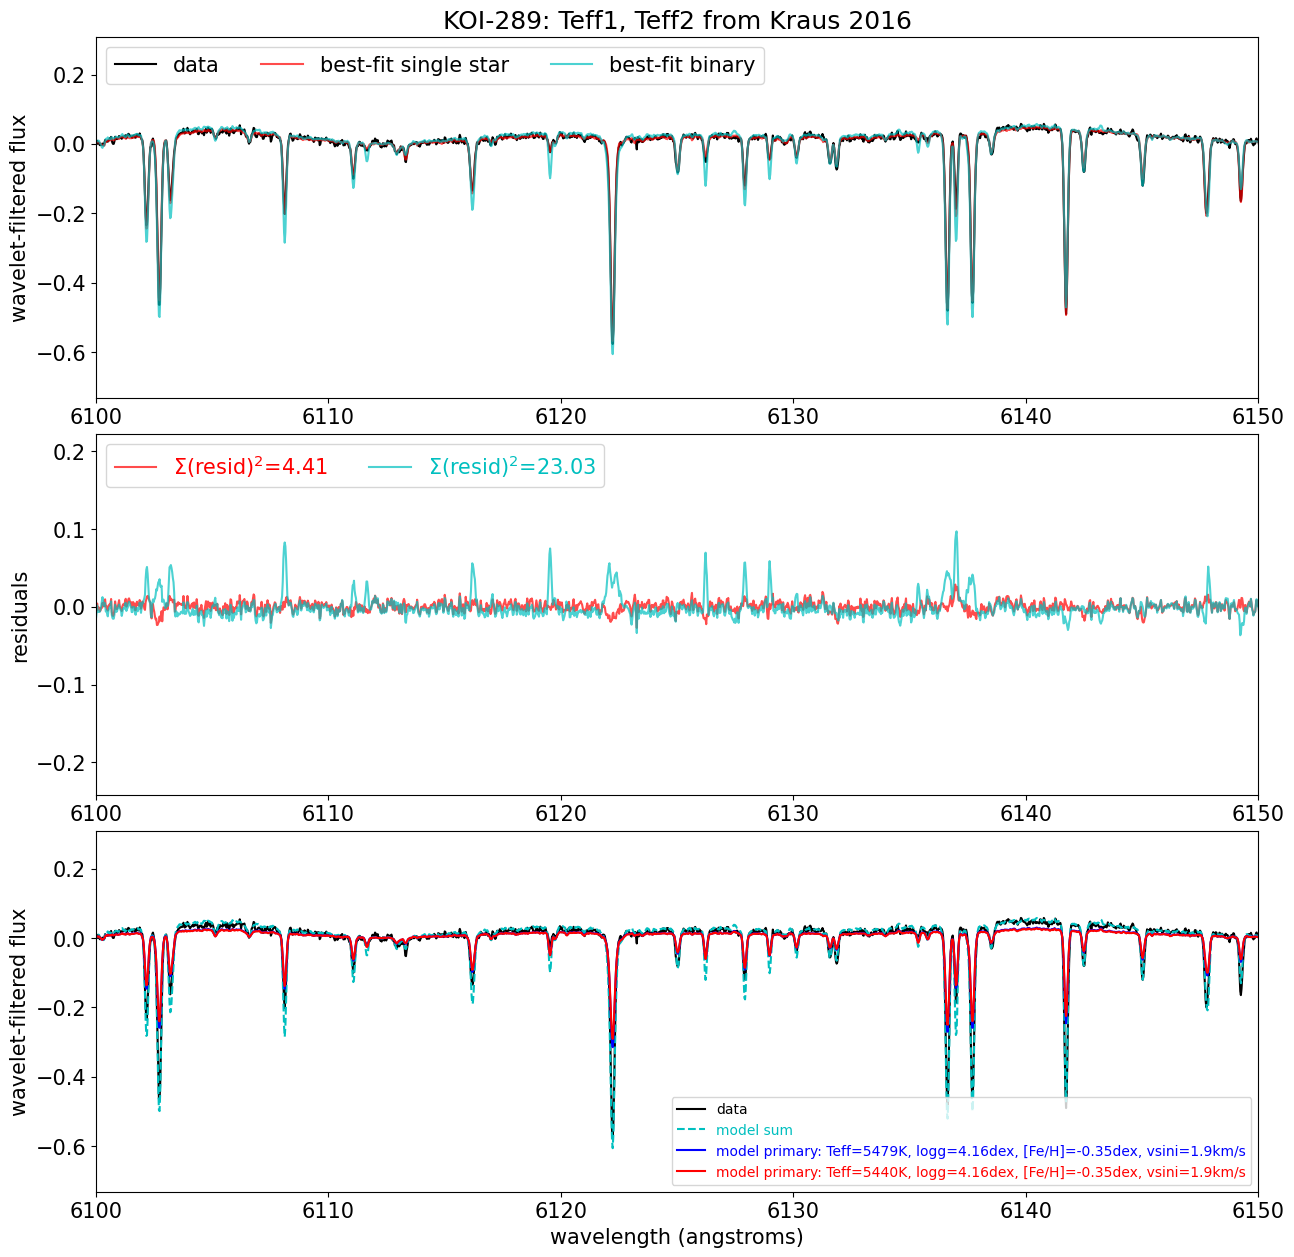

In [5]:
# first plot: 
# q=1 binary
# primary teff, secondary teff from Kraus 2016
# other labels are reported from CKS (assumes single star)

# primary, secondary labels
q1_primary_default_labels = [float(q1_teff1)]+q1_cks_labels[['cks_slogg', 'cks_smet', 'cks_svsini']].tolist()
q1_secondary_default_labels = [float(q1_teff2)]+q1_cks_labels[['cks_slogg', 'cks_smet', 'cks_svsini']].tolist()

plot_binary(
    q1_spec, 
    q1_primary_default_labels, 
    q1_secondary_default_labels,
    title_str = 'KOI-289: Teff1, Teff2 from Kraus 2016')

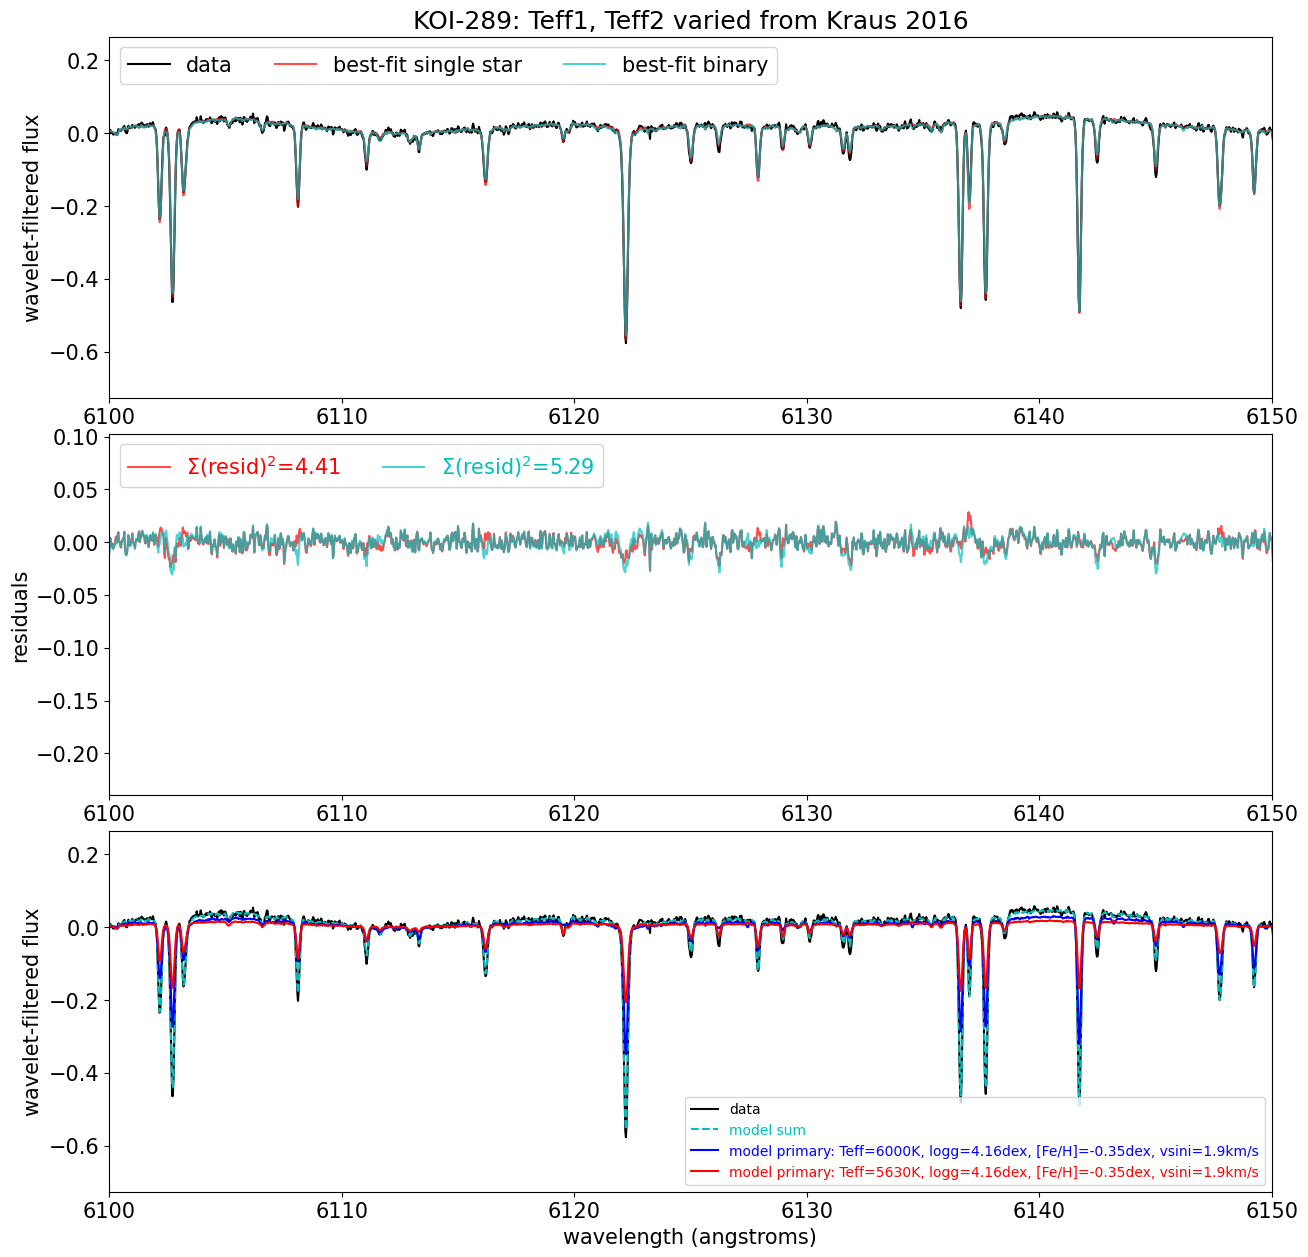

In [6]:
# second plot: 
# q=1 binary
# primary teff, secondary teff tweaked to find a better fit
# other labels are reported from CKS (assumes single star)
# note: these labels match the specmatch-emp labels better as well.

# primary, secondary labels
q1_primary_updated_labels = q1_primary_default_labels.copy()
q1_secondary_updated_labels = q1_secondary_default_labels.copy()

q1_primary_updated_labels[0] = 6000
q1_secondary_updated_labels[0] = 5630

plot_binary(
    q1_spec, 
    q1_primary_updated_labels, 
    q1_secondary_updated_labels,
    title_str = 'KOI-289: Teff1, Teff2 varied from Kraus 2016')

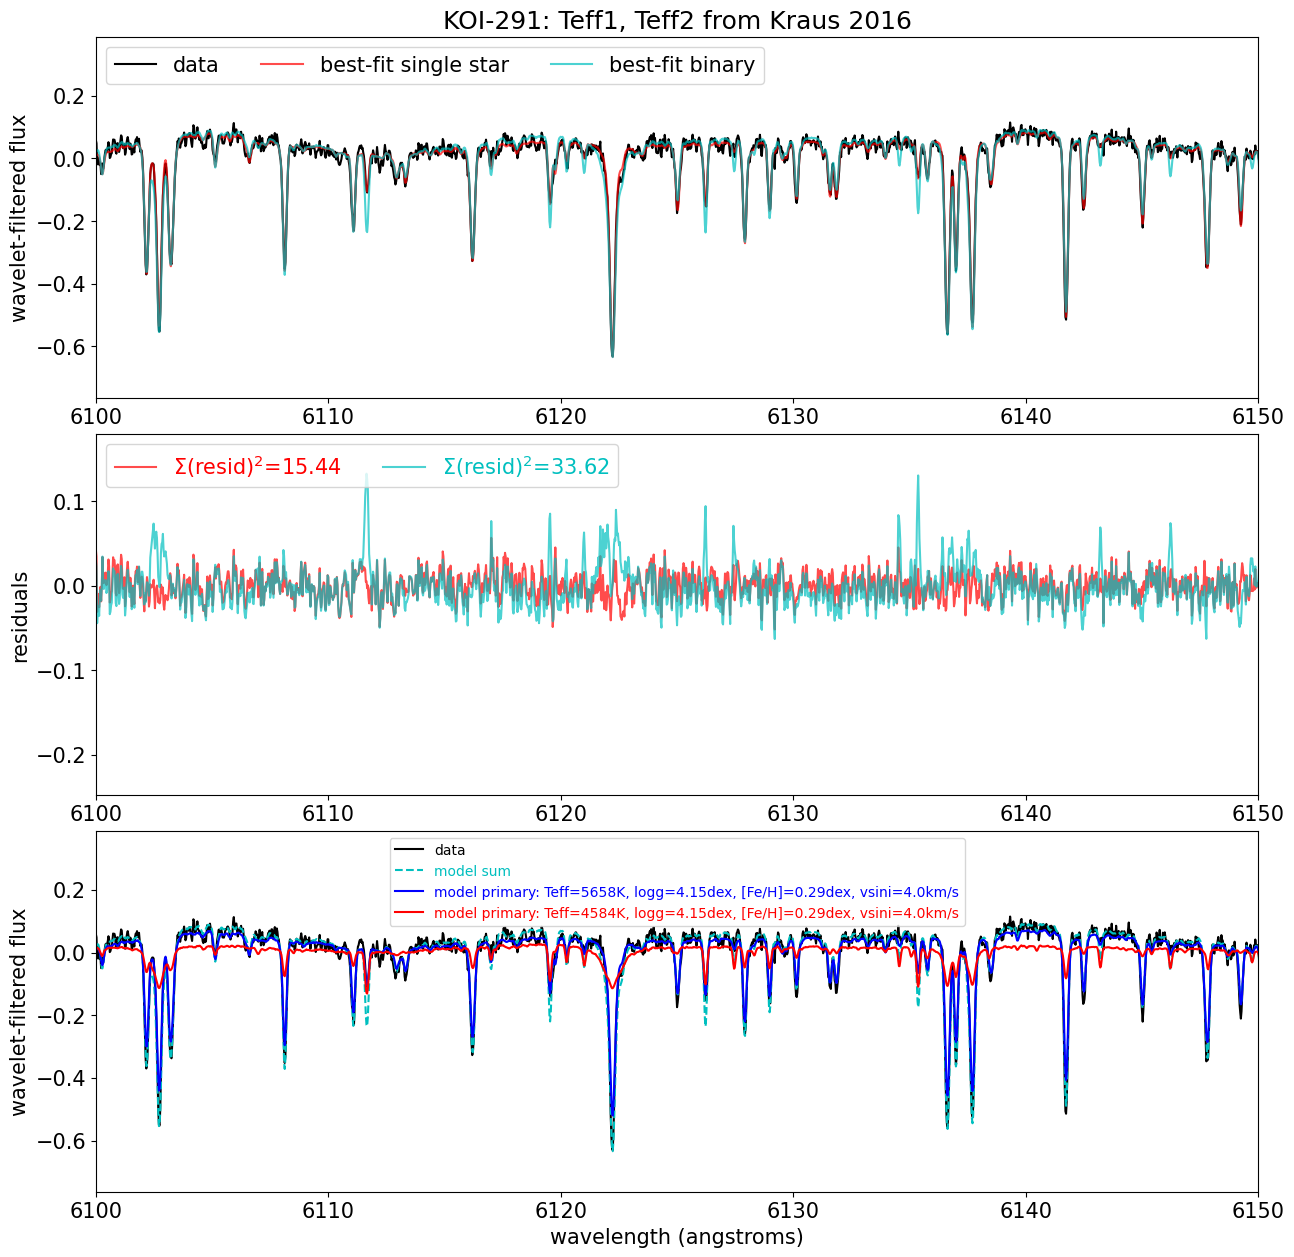

In [7]:
# third plot: 
# q=0.7 binary
# primary teff, secondary teff from Kraus 2016
# other labels are reported from CKS (assumes single star)
# note: these labels better match the specmatch-emp labels

# primary, secondary labels
q07_primary_default_labels = [float(q07_teff1)]+q07_cks_labels[['cks_slogg', 'cks_smet', 'cks_svsini']].tolist()
q07_secondary_default_labels = [float(q07_teff2)]+q07_cks_labels[['cks_slogg', 'cks_smet', 'cks_svsini']].tolist()

plot_binary(
    q07_spec, 
    q07_primary_default_labels, 
    q07_secondary_default_labels,
    title_str = 'KOI-291: Teff1, Teff2 from Kraus 2016')

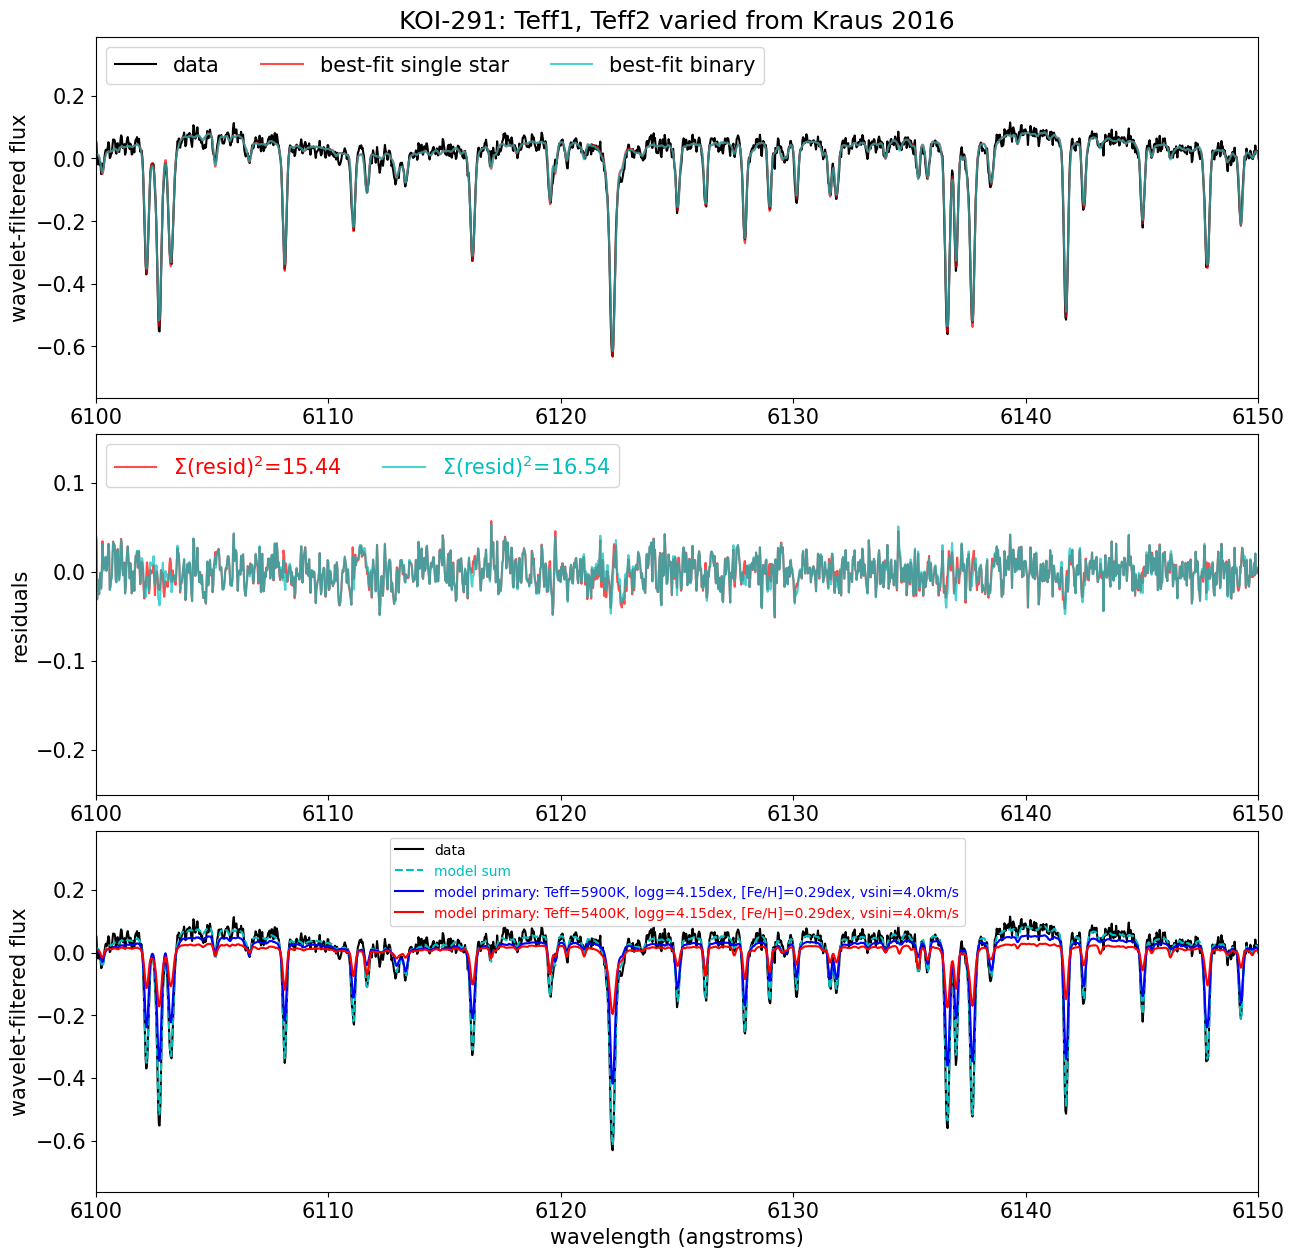

In [8]:
# fourth plot: 
# q=0.7 binary
# [INSERT PARAMETERS] are tweaked to get a better fit
# other labels are reported from CKS (assumes single star)
# note: these labels match the specmatch-emp labels better as well.

# these look like teff residuals.
# problem: this isn't helping at all?
# I think there's a typo.

# primary, secondary labels
q07_primary_updated_labels = q07_primary_default_labels.copy()
q07_secondary_updated_labels = q07_secondary_default_labels.copy()

q07_primary_updated_labels[0] = 5900
q07_secondary_updated_labels[0] = 5400

plot_binary(
    q07_spec, 
    q07_primary_updated_labels, 
    q07_secondary_updated_labels,
    title_str = 'KOI-291: Teff1, Teff2 varied from Kraus 2016')

Text(0, 0.5, 'residuals')

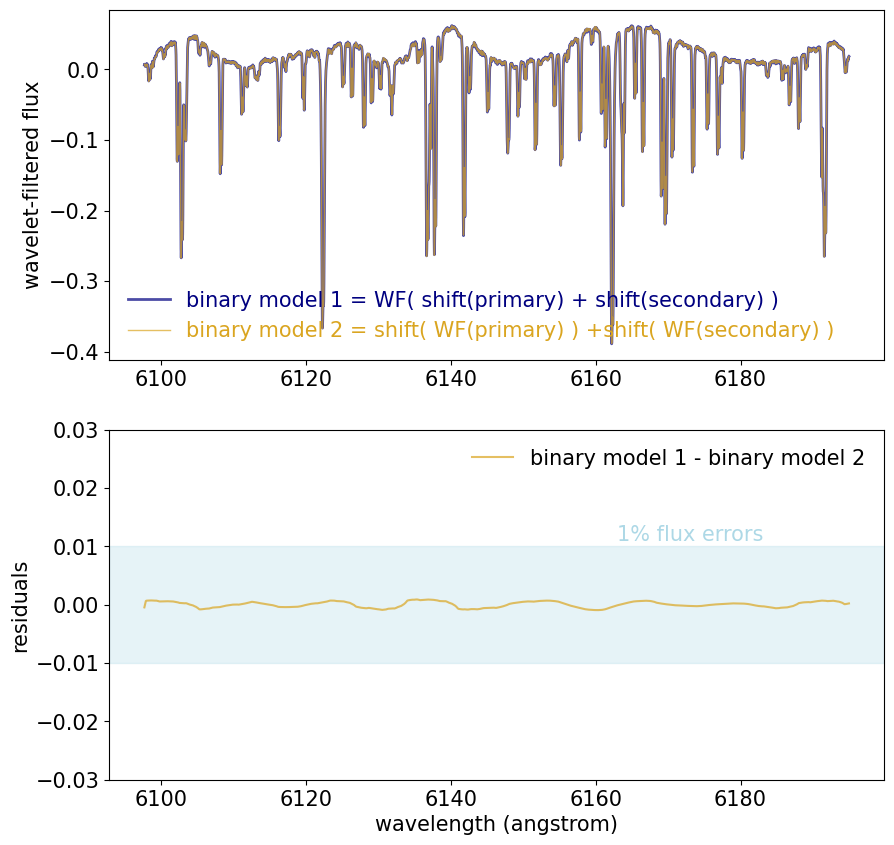

In [31]:
# model 1: filter(W1*primary + W2*secondary)
# model 2: filter(W1*primary) + filter(W2*secondary)
# model 3: W1*filter(primary) + W2*filter(secondary)

import dwt

dwt_model = tc.CannonModel.read('./data/cannon_models/rchip_order14_dwt/rchip_order14_dwt.model')
original_model = tc.CannonModel.read('./data/cannon_models/rchip_order14_original/rchip_order14_original.model')
w_order = spectrum.w_data[[i-1 for i in [14]]].flatten()

# speed of light for doppler shift calculation
import astropy.units as u
import astropy.constants as c
speed_of_light_kms = c.c.to(u.km/u.s).value

# model 1: 
#  filter( shift(W1*primary) + shift(W2*secondary) )
def model1(primary_labels, secondary_labels, rv1, rv2):
    # compute flux weights
    W1, W2 = flux_weights(primary_labels[0], secondary_labels[0], w_order)
    # compute weighted fluxes from cannon model
    flux1 = W1*original_model(primary_labels)
    flux2 = W2*original_model(secondary_labels)
    # shift flux1, flux2 according to drv
    delta_w1 = w_order * rv1/speed_of_light_kms
    delta_w2 = w_order * rv2/speed_of_light_kms
    flux1_shifted = np.interp(w_order, w_order + delta_w1, flux1)
    flux2_shifted = np.interp(w_order, w_order + delta_w2, flux2)
    # combine fluxes
    flux_combined = flux1_shifted + flux2_shifted
    # perform wavelet transform
    flux_combined_dwt = dwt.flux_waverec(flux_combined, 'sym5', np.arange(1,1+8,1))
    return flux_combined_dwt
    
# model 2: 
# W1*shift(filter(primary)) + W2*shift(filter(secondary)), OR
# shift( W1*filter(primary) ) + shift( W2*filter(secondary) ) 
def model2(primary_labels, secondary_labels, rv1, rv2):
    # compute flux weights
    W1, W2 = flux_weights(primary_labels[0], secondary_labels[0], w_order)
    # compute weighted, wavelet filtered fluxes from cannon model
    flux1_dwt = dwt.flux_waverec(original_model(primary_labels), 'sym5', np.arange(1,8+1,1))
    flux2_dwt = dwt.flux_waverec(original_model(secondary_labels), 'sym5', np.arange(1,8+1,1))
    # shift flux1, flux2 according to drv
    delta_w1 = w_order * rv1/speed_of_light_kms
    delta_w2 = w_order * rv2/speed_of_light_kms
    flux1_shifted_dwt = np.interp(w_order, w_order + delta_w1, flux1_dwt)
    flux2_shifted_dwt = np.interp(w_order, w_order + delta_w2, flux2_dwt)
    # combine fluxes
    flux_combined_dwt = W1*flux1_shifted_dwt + W2*flux2_shifted_dwt
    return flux_combined_dwt
    
model1_binary = model1(q1_primary_default_labels, q1_secondary_default_labels, 0, 10)
model2_binary = model3(q1_primary_default_labels, q1_secondary_default_labels, 0, 10)

figure(figsize=(10,10))
subplot(211)
plot(w_order, model1_binary, color='navy', 
     label='binary model 1 = WF( shift(primary) + shift(secondary) )', alpha=0.7, lw=2)
plot(w_order, model2_binary, color='goldenrod', 
     label='binary model 2 = shift( WF(primary) ) +shift( WF(secondary) )', alpha=0.7, lw=1)
legend(frameon=False, labelcolor='linecolor')
ylabel('wavelet-filtered flux')

subplot(212)
axhspan(-0.01,0.01,alpha=0.3,color='lightblue')
text(6163,0.011,'1% flux errors', color='lightblue')
plot(w_order, model1_binary - model2_binary, color='goldenrod', alpha=0.7, 
     label='binary model 1 - binary model 2')
ylim(-0.03,0.03)
legend(frameon=False)
xlabel('wavelength (angstrom)')
ylabel('residuals')